## A. Sample person and cyclist annotations from the annotations
- COCO 2017 train/val dataset (80 classes, 123,287 images, 886,284 instances).
- Read annotations/instances_{train,val}2017.json
- Filter images with [person, bicycle]
- Add a new class label, outer-bounding-box called `cyclist` if `person` & `bicycle` have IoU>20%
- Dump the new annotations to a new file suffixed `cyclist`


## i.) Read, Filter & Export Annotations

### Dataset sampler and YOLOX Detector folder structure
```
Capstone Project
│
└───samples
|   │
|   └───coco_dataset.py
|   └───coco_sampler.ipynb
|   └───proposal.pdf
|
│
└───YOLOX/
    │
    └───tools/train.py
    │
    └───datasets/COCOdataset2017   
        └───images
        │   └───train
        │   │    │   000000000009.jpg
        │   │    │   000000000025.jpg
        │   │    │   ...
        │   └───val   
        │        │   000000000139.jpg
        │        │   000000000285.jpg
        │        │   ...
        └───annotations
            │   instances_train.json
            │   instances_val.json
            |   ...
```

In [1]:
import os
import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from coco_dataset import COCODatasetCustom

In [2]:
COCO_DATA_HOME = "/media/rahul/HIT-GRAID/data/coco"

In [3]:
# List the files in the folder
! ls -lh $COCO_DATA_HOME/annotations/instances*

-rwxrwxrwx 1 rahul rahul 513K Jul 10  2019 /media/rahul/HIT-GRAID/data/coco/annotations/instances_minival2014_100.json
-rwxrwxrwx 1 rahul rahul 449M Sep  1  2017 /media/rahul/HIT-GRAID/data/coco/annotations/instances_train2017.json
-rwxrwxrwx 1 rahul rahul 1.2M Aug  7  2020 /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017_100.json
-rwxrwxrwx 1 rahul rahul  73M Jul 23  2021 /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017.json


#### COCO Annotations structure in JSON format

> Extracts from `annotations/instances_*2017.json`
```
{
    "categories": [
        {
            "id": 1,
            "name": "person",
            "supercategory": "person"
        },
        {
            "id": 2,
            "name": "bicycle",
            "supercategory": "vehicle"
        }
    ],
    "images": [
        {
            "id": 0,
            "license": 1,
            "file_name": "<filename0>.<ext>",
            "height": 480,
            "width": 640,
            "date_captured": null
        }
    ],
    "annotations": [
        {
            "id": 0,
            "image_id": 0,
            "category_id": 2,
            "bbox": [ 260, 177, 231, 199 ],
            "segmentation": [ ],
            "area": 45969,
            "iscrowd": 0
        }
    ]
}
```

> We are interested in category `person` and `bicycle`

In [4]:
def read_annotations(ann_type, allowed_list=["person", "bicycle"]):
    ann_file = "instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type, selected_categories=allowed_list)   
    coco_custom.export_anns(os.path.join(COCO_DATA_HOME, "annotations", "sampled_{}".format(ann_file)), True)
    return coco_custom

In [5]:
anns_dict = {}
for ann in ["train2017", "val2017"]:
    anns_dict[ann] = read_annotations(ann)

loading annotations into memory...
Done (t=9.07s)
creating index...
index created!
Read annotations for 2643 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/instances_train2017.json
New Annotations: 1609/21797
Export 23406 annotations for 2643 images to -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_train2017.json
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Read annotations for 122 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017.json
New Annotations: 59/1048
Export 1107 annotations for 122 images to -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_val2017.json


In [6]:
val2017 = anns_dict["val2017"]

In [7]:
for cat in val2017.cats[0:10]:
    print("Cats: ", cat)

Cats:  {'supercategory': 'person', 'id': 1, 'name': 'person'}
Cats:  {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
Cats:  {'supercategory': 'person', 'id': 101, 'name': 'cyclist'}


In [8]:
print("Classes: ",val2017._classes)

Classes:  ('person', 'bicycle')


In [9]:
print("Class IDs: ",val2017.class_ids)

Class IDs:  [1, 2]


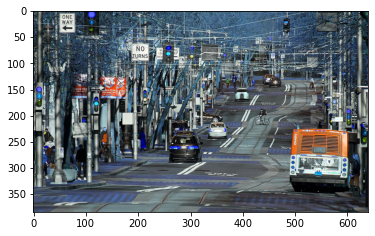

In [10]:
plt.imshow(val2017.load_image(35))

## ii.) New Annotations

In [17]:
def show_ann_type(ann_type, index):
    ann_file = "sampled_instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type)   
    print("Number of images (all classes):", len(coco_custom.ids))
    imgids = coco_custom.coco.getImgIds(catIds=[101])
    print("Image Ids for Bicyclist: ",len(imgids))
    plt.imshow(coco_custom.load_image(index))

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Read annotations for 2643 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_train2017.json
Number of images (all classes): 2643
Image Ids for Bicyclist:  1112


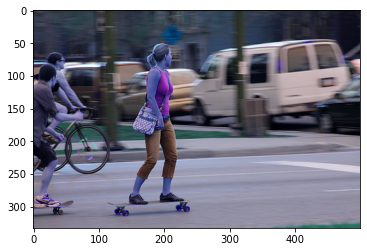

In [23]:
show_ann_type(ann_type="train2017", index = 53)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Read annotations for 122 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_val2017.json
Number of images (all classes): 122
Image Ids for Bicyclist:  45


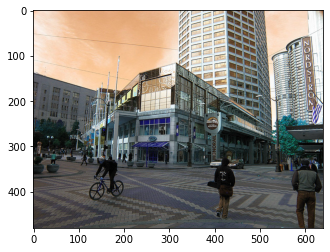

In [24]:
show_ann_type(ann_type="val2017", index = 100)

### iii.) Sampled Dataset creation

In [41]:
TARGET_COCO_DATA_HOME = "./data/cocobi"

In [42]:
import shutil

def copy_ann_images(ann_type):
    ann_file = "sampled_instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type)   
    print("Number of images (all classes):", len(coco_custom.ids))
    imgids = coco_custom.coco.getImgIds()
    ims = coco_custom.coco.loadImgs(imgids)
    print("Image Ids for Bicyclist: ", len(ims))
    ann_outfolder = os.path.join(TARGET_COCO_DATA_HOME, ann_type)
    for idx, im in enumerate(ims):
        im_filepath = os.path.join(COCO_DATA_HOME, ann_type, im['file_name'])
        #print(idx, "\t", im_filepath) # /media/rahul/HIT-GRAID/data/coco/val2017
        shutil.copy(im_filepath, ann_outfolder)

In [43]:
copy_ann_images(ann_type="val2017")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Read annotations for 122 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_val2017.json
Number of images (all classes): 122
Image Ids for Bicyclist:  122


In [44]:
copy_ann_images(ann_type="train2017")

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Read annotations for 2643 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_train2017.json
Number of images (all classes): 2643
Image Ids for Bicyclist:  2643
